# import libraries

In [33]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

# read and preprocess images

In [15]:
X, y = fetch_openml(
    'mnist_784',
    version=1,
    as_frame=False,
    return_X_y=True
)

split X and y

In [16]:
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42,
    stratify=y
)


print(f"X.shape: {X_train.shape}")
print(f"y.shape: {y_train.shape}")

X.shape: (49000, 784)
y.shape: (49000,)


normalize dataset

In [17]:
X_train = X_train.astype(np.float32) / 255.0

display images

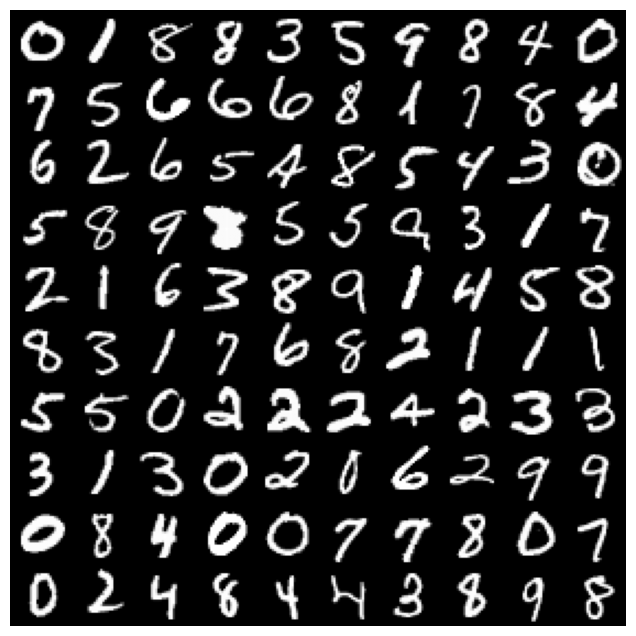

In [18]:
# take first 100 images
imgs = X_train[:100].reshape(100, 28, 28)

# reshape into 10x10 grid
grid = imgs.reshape(10, 10, 28, 28)

# stitch images: (rows, height, cols, width) → (rows*height, cols*width)
stitched = np.block([[grid[i, j] for j in range(10)] for i in range(10)])

plt.figure(figsize=(8, 8))
plt.imshow(stitched, cmap='gray')
plt.axis('off')
plt.show()

# train kmeans with different values of k

In [19]:
kmeans = {}
ks = list(range(8, 12))

for k in ks:
    print(f"train KMeans for K = {k} ...")
    kmeans[k] = KMeans(n_clusters=k, random_state=42).fit(X_train)

train KMeans for K = 8 ...
train KMeans for K = 9 ...
train KMeans for K = 10 ...
train KMeans for K = 11 ...


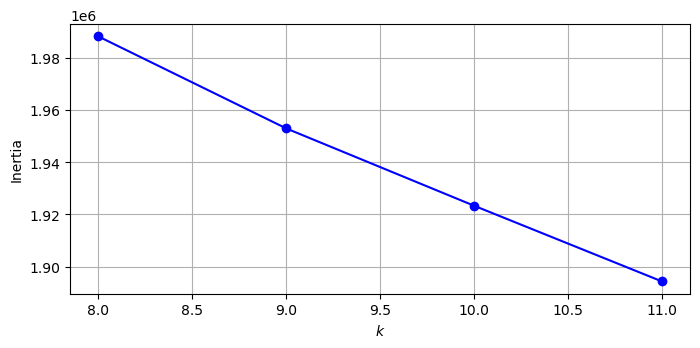

In [20]:
inertias = [kmeans[k].inertia_ for k in ks]

plt.figure(figsize=(8, 3.5))
plt.plot(ks, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
# plt.annotate("", xy=(13, inertias[5]), xytext=(13, 365000),
#              arrowprops=dict(facecolor='black', shrink=0.3))
# plt.text(13, 365000, "Elbow", horizontalalignment="center")
plt.grid()

plt.show()

silhouette scores

In [22]:
silhouette_scores = [silhouette_score(X_train, kmeans[k].labels_)
                     for k in ks]

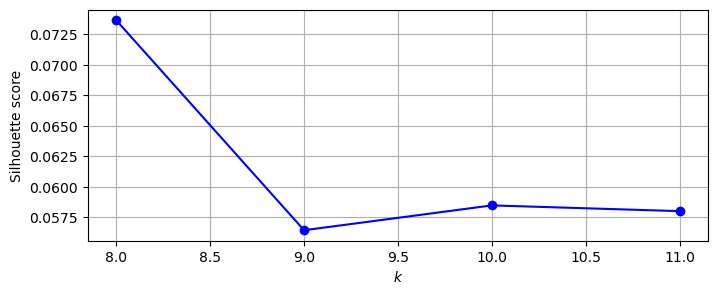

In [23]:
plt.figure(figsize=(8, 3))
plt.plot(ks, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

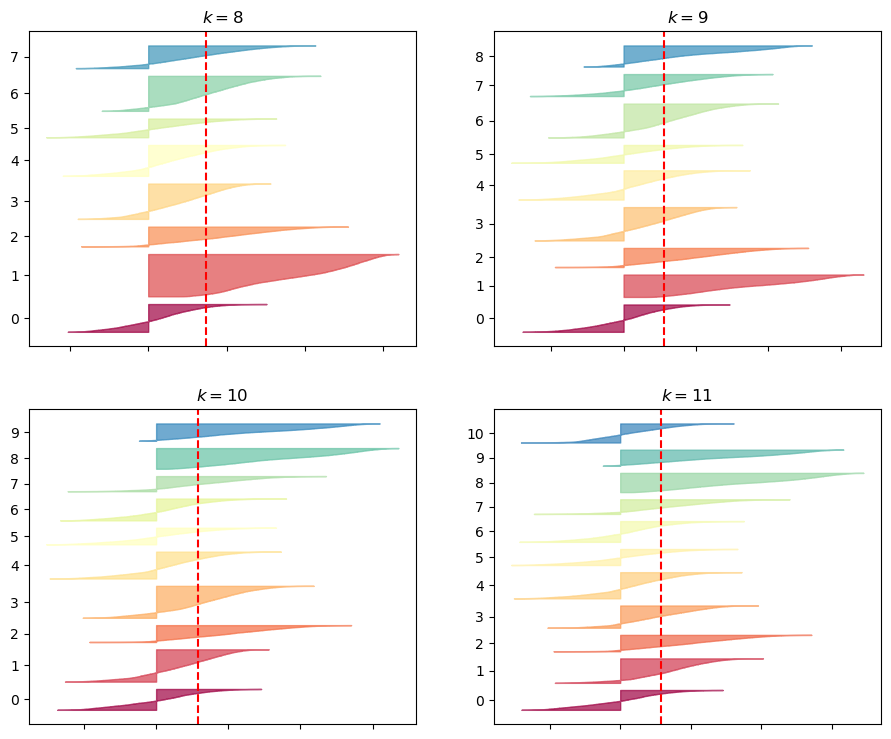

In [27]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in ks:
    plt.subplot(2, 2, k - 7)

    y_pred = kmeans[k].labels_
    silhouette_coefficients = silhouette_samples(X_train, y_pred)

    padding = len(X_train) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 8], color="red", linestyle="--")
    plt.title(f"$k={k}$")


plt.show()

In [31]:
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / cm.sum()

In [34]:
for k in ks:
    y_pred = kmeans[k].labels_
    ari = adjusted_rand_score(y_train, y_pred)
    nmi = normalized_mutual_info_score(y_train, y_pred)
    accuracy = clustering_accuracy(y_train, y_pred)
    print(f"ari for k = {k} = {ari}")
    print(f"nmi for k = {k} = {nmi}")
    print(f"acc for k = {k} = {accuracy}")
    print("*" * 30)
    

ari for k = 8 = 0.39622551773112274
nmi for k = 8 = 0.506726418687177
acc for k = 8 = 0.5790612244897959
******************************
ari for k = 9 = 0.3719277585871924
nmi for k = 9 = 0.4926141456350802
acc for k = 9 = 0.5402653061224489
******************************
ari for k = 10 = 0.3627216402287547
nmi for k = 10 = 0.49829892967626094
acc for k = 10 = 0.528
******************************
ari for k = 11 = 0.36044001638636114
nmi for k = 11 = 0.49634401581117715
acc for k = 11 = 0.5338367346938776
******************************


مقدار سه عدد ارتباطی به هم ندارند. 
ان ام آی و صحت پیش بینی تصادفی را در نظر نمی‌گیرند.



الگوریتم به خوبی عمل نکرده است. چون ارقام دارای ویژگیهایی بصری نظیر زاویه و شکل ارقام است که الگوریتم آنها را در نظر نمیگیرد. و صرفا بر اساس مقدار عددی پیکسلها رفتار میکند و چون برخی اعداد میتوانند از لحاظ این ویژگیها نزدیک هم باشند مدل آنها را درون یک خوشه قرار دهد. 